In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from tqdm.notebook import tqdm
from matplotlib.image import imread, imsave
from skimage.color import rgb2lab, lab2rgb
from apex import amp
from torch.utils.data import Dataset, DataLoader
from torchvision import models

In [5]:
torch.backends.cudnn.benchmark = True

## Data

In [6]:
def unpack_dataset():
    ! mkdir -p data
    
#     # train dataset
#     ! wget http://data.csail.mit.edu/places/places365/train_256_places365standard.tar
#     ! tar -xvf train_256_places365standard.tar -C data
    
    # validation dataset
    ! wget -c http://data.csail.mit.edu/places/places365/val_256.tar
    ! tar -xvf val_256.tar -C data
    
#     # test dataset
#     ! wget http://data.csail.mit.edu/places/places365/test_256.tar
#     ! tar -xvf test_256.tar -C data

In [7]:
unpack_dataset()

--2020-06-23 19:58:01--  http://data.csail.mit.edu/places/places365/val_256.tar
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525158400 (501M) [application/octet-stream]
Saving to: ‘val_256.tar’

val_256.tar         100%[===================>] 500.83M  1.91MB/s    in 6m 55s  

2020-06-23 20:05:19 (1.21 MB/s) - ‘val_256.tar’ saved [525158400/525158400]

val_256/
val_256/Places365_val_00035900.jpg
val_256/Places365_val_00035572.jpg
val_256/Places365_val_00002949.jpg
val_256/Places365_val_00007265.jpg
val_256/Places365_val_00019005.jpg
val_256/Places365_val_00027775.jpg
val_256/Places365_val_00015062.jpg
val_256/Places365_val_00014185.jpg
val_256/Places365_val_00026692.jpg
val_256/Places365_val_00006857.jpg
val_256/Places365_val_00006425.jpg
val_256/Places365_val_00034332.jpg
val_256/Places365_val_00014622.jpg
val_256/Places365_va

val_256/Places365_val_00003639.jpg
val_256/Places365_val_00034670.jpg
val_256/Places365_val_00006167.jpg
val_256/Places365_val_00026477.jpg
val_256/Places365_val_00026805.jpg
val_256/Places365_val_00023329.jpg
val_256/Places365_val_00014360.jpg
val_256/Places365_val_00031689.jpg
val_256/Places365_val_00018307.jpg
val_256/Places365_val_00009015.jpg
val_256/Places365_val_00005072.jpg
val_256/Places365_val_00025910.jpg
val_256/Places365_val_00025562.jpg
val_256/Places365_val_00012959.jpg
val_256/Places365_val_00017275.jpg
val_256/Places365_val_00029505.jpg
val_256/Places365_val_00029977.jpg
val_256/Places365_val_00004632.jpg
val_256/Places365_val_00036125.jpg
val_256/Places365_val_00028890.jpg
val_256/Places365_val_00008655.jpg
val_256/Places365_val_00016392.jpg
val_256/Places365_val_00024485.jpg
val_256/Places365_val_00004195.jpg
val_256/Places365_val_00028345.jpg
val_256/Places365_val_00016847.jpg
val_256/Places365_val_00016435.jpg
val_256/Places365_val_00024322.jpg
val_256/Places365_va

val_256/Places365_val_00011839.jpg
val_256/Places365_val_00005007.jpg
val_256/Places365_val_00000759.jpg
val_256/Places365_val_00009060.jpg
val_256/Places365_val_00029902.jpg
val_256/Places365_val_00029570.jpg
val_256/Places365_val_00020249.jpg
val_256/Places365_val_00017200.jpg
val_256/Places365_val_00025517.jpg
val_256/Places365_val_00025965.jpg
val_256/Places365_val_00024882.jpg
val_256/Places365_val_00008620.jpg
val_256/Places365_val_00036150.jpg
val_256/Places365_val_00028497.jpg
val_256/Places365_val_00001119.jpg
val_256/Places365_val_00004647.jpg
val_256/Places365_val_00024357.jpg
val_256/Places365_val_00016440.jpg
val_256/Places365_val_00016832.jpg
val_256/Places365_val_00021409.jpg
val_256/Places365_val_00008187.jpg
val_256/Places365_val_00028330.jpg
val_256/Places365_val_00018637.jpg
val_256/Places365_val_00034895.jpg
val_256/Places365_val_00023619.jpg
val_256/Places365_val_00014650.jpg
val_256/Places365_val_00026147.jpg
val_256/Places365_val_00006825.jpg
val_256/Places365_va

val_256/Places365_val_00030830.jpg
val_256/Places365_val_00010152.jpg
val_256/Places365_val_00022645.jpg
val_256/Places365_val_00002880.jpg
val_256/Places365_val_00008579.jpg
val_256/Places365_val_00001240.jpg
val_256/Places365_val_00036209.jpg
val_256/Places365_val_00033925.jpg
val_256/Places365_val_00033557.jpg
val_256/Places365_val_00013047.jpg
val_256/Places365_val_00021750.jpg
val_256/Places365_val_00016719.jpg
val_256/Places365_val_00001995.jpg
val_256/Places365_val_00028069.jpg
val_256/Places365_val_00032317.jpg
val_256/Places365_val_00000872.jpg
val_256/Places365_val_00000400.jpg
val_256/Places365_val_00009339.jpg
val_256/Places365_val_00029629.jpg
val_256/Places365_val_00017159.jpg
val_256/Places365_val_00020110.jpg
val_256/Places365_val_00012607.jpg
val_256/Places365_val_00022583.jpg
val_256/Places365_val_00010294.jpg
val_256/Places365_val_00030023.jpg
val_256/Places365_val_00002734.jpg
val_256/Places365_val_00022224.jpg
val_256/Places365_val_00010941.jpg
val_256/Places365_va

val_256/Places365_val_00022527.jpg
val_256/Places365_val_00022955.jpg
val_256/Places365_val_00002790.jpg
val_256/Places365_val_00030087.jpg
val_256/Places365_val_00019509.jpg
val_256/Places365_val_00010597.jpg
val_256/Places365_val_00022280.jpg
val_256/Places365_val_00002037.jpg
val_256/Places365_val_00030720.jpg
val_256/Places365_val_00007769.jpg
val_256/Places365_val_00012104.jpg
val_256/Places365_val_00020613.jpg
val_256/Places365_val_00000303.jpg
val_256/Places365_val_00032414.jpg
val_256/Places365_val_00032866.jpg
val_256/Places365_val_00009848.jpg
val_256/Places365_val_00021053.jpg
val_256/Places365_val_00013744.jpg
val_256/Places365_val_00033981.jpg
val_256/Places365_val_00033254.jpg
val_256/Places365_val_00001543.jpg
val_256/Places365_val_00001931.jpg
val_256/Places365_val_00022146.jpg
val_256/Places365_val_00027618.jpg
val_256/Places365_val_00010651.jpg
val_256/Places365_val_00030894.jpg
val_256/Places365_val_00019168.jpg
val_256/Places365_val_00007308.jpg
val_256/Places365_va

val_256/Places365_val_00006285.jpg
val_256/Places365_val_00018742.jpg
val_256/Places365_val_00034592.jpg
val_256/Places365_val_00014725.jpg
val_256/Places365_val_00026032.jpg
val_256/Places365_val_00035475.jpg
val_256/Places365_val_00035807.jpg
val_256/Places365_val_00007362.jpg
val_256/Places365_val_00027672.jpg
val_256/Places365_val_00015165.jpg
val_256/Places365_val_00019102.jpg
val_256/Places365_val_00002105.jpg
val_256/Places365_val_00030612.jpg
val_256/Places365_val_00010302.jpg
val_256/Places365_val_00022867.jpg
val_256/Places365_val_00022415.jpg
val_256/Places365_val_00019849.jpg
val_256/Places365_val_00031052.jpg
val_256/Places365_val_00003745.jpg
val_256/Places365_val_00023980.jpg
val_256/Places365_val_00023255.jpg
val_256/Places365_val_00026979.jpg
val_256/Places365_val_00011930.jpg
val_256/Places365_val_00011542.jpg
val_256/Places365_val_00032147.jpg
val_256/Places365_val_00000650.jpg
val_256/Places365_val_00009169.jpg
val_256/Places365_val_00020895.jpg
val_256/Places365_va

val_256/Places365_val_00024373.jpg
val_256/Places365_val_00016816.jpg
val_256/Places365_val_00016464.jpg
val_256/Places365_val_00035061.jpg
val_256/Places365_val_00002028.jpg
val_256/Places365_val_00007776.jpg
val_256/Places365_val_00010588.jpg
val_256/Places365_val_00019964.jpg
val_256/Places365_val_00030098.jpg
val_256/Places365_val_00019516.jpg
val_256/Places365_val_00027266.jpg
val_256/Places365_val_00015571.jpg
val_256/Places365_val_00015903.jpg
val_256/Places365_val_00022538.jpg
val_256/Places365_val_00014496.jpg
val_256/Places365_val_00026381.jpg
val_256/Places365_val_00006136.jpg
val_256/Places365_val_00018883.jpg
val_256/Places365_val_00003668.jpg
val_256/Places365_val_00034621.jpg
val_256/Places365_val_00023378.jpg
val_256/Places365_val_00014331.jpg
val_256/Places365_val_00026426.jpg
val_256/Places365_val_00026854.jpg
val_256/Places365_val_00018356.jpg
val_256/Places365_val_00006691.jpg
val_256/Places365_val_00034186.jpg
val_256/Places365_val_00004202.jpg
val_256/Places365_va

val_256/Places365_val_00023491.jpg
val_256/Places365_val_00022576.jpg
val_256/Places365_val_00022904.jpg
val_256/Places365_val_00010261.jpg
val_256/Places365_val_00027228.jpg
val_256/Places365_val_00019558.jpg
val_256/Places365_val_00035788.jpg
val_256/Places365_val_00015298.jpg
val_256/Places365_val_00030771.jpg
val_256/Places365_val_00007738.jpg
val_256/Places365_val_00002066.jpg
val_256/Places365_val_00016858.jpg
val_256/Places365_val_00021811.jpg
val_256/Places365_val_00021463.jpg
val_256/Places365_val_00013374.jpg
val_256/Places365_val_00033664.jpg
val_256/Places365_val_00001173.jpg
val_256/Places365_val_00029968.jpg
val_256/Places365_val_00000094.jpg
val_256/Places365_val_00032783.jpg
val_256/Places365_val_00012946.jpg
val_256/Places365_val_00012534.jpg
val_256/Places365_val_00020223.jpg
val_256/Places365_val_00000733.jpg
val_256/Places365_val_00032024.jpg
val_256/Places365_val_00012293.jpg
val_256/Places365_val_00020584.jpg
val_256/Places365_val_00012997.jpg
val_256/Places365_va

val_256/Places365_val_00011035.jpg
val_256/Places365_val_00023722.jpg
val_256/Places365_val_00003595.jpg
val_256/Places365_val_00031282.jpg
val_256/Places365_val_00011792.jpg
val_256/Places365_val_00023085.jpg
val_256/Places365_val_00003232.jpg
val_256/Places365_val_00031525.jpg
val_256/Places365_val_00031957.jpg
val_256/Places365_val_00012120.jpg
val_256/Places365_val_00025169.jpg
val_256/Places365_val_00020637.jpg
val_256/Places365_val_00000480.jpg
val_256/Places365_val_00032397.jpg
val_256/Places365_val_00012687.jpg
val_256/Places365_val_00020190.jpg
val_256/Places365_val_00000327.jpg
val_256/Places365_val_00032842.jpg
val_256/Places365_val_00032430.jpg
val_256/Places365_val_00005479.jpg
val_256/Places365_val_00036289.jpg
val_256/Places365_val_00021077.jpg
val_256/Places365_val_00024729.jpg
val_256/Places365_val_00013760.jpg
val_256/Places365_val_00004239.jpg
val_256/Places365_val_00033270.jpg
val_256/Places365_val_00001915.jpg
val_256/Places365_val_00001567.jpg
val_256/Places365_va

val_256/Places365_val_00010949.jpg
val_256/Places365_val_00027900.jpg
val_256/Places365_val_00027572.jpg
val_256/Places365_val_00015265.jpg
val_256/Places365_val_00019202.jpg
val_256/Places365_val_00006622.jpg
val_256/Places365_val_00034135.jpg
val_256/Places365_val_00014382.jpg
val_256/Places365_val_00026495.jpg
val_256/Places365_val_00018442.jpg
val_256/Places365_val_00018830.jpg
val_256/Places365_val_00006185.jpg
val_256/Places365_val_00034692.jpg
val_256/Places365_val_00014857.jpg
val_256/Places365_val_00014425.jpg
val_256/Places365_val_00026332.jpg
val_256/Places365_val_00005737.jpg
val_256/Places365_val_00000069.jpg
val_256/Places365_val_00029995.jpg
val_256/Places365_val_00017297.jpg
val_256/Places365_val_00009750.jpg
val_256/Places365_val_00025580.jpg
val_256/Places365_val_00005090.jpg
val_256/Places365_val_00029240.jpg
val_256/Places365_val_00020579.jpg
val_256/Places365_val_00017530.jpg
val_256/Places365_val_00017942.jpg
val_256/Places365_val_00025227.jpg
val_256/Places365_va

val_256/Places365_val_00019160.jpg
val_256/Places365_val_00035865.jpg
val_256/Places365_val_00035417.jpg
val_256/Places365_val_00007300.jpg
val_256/Places365_val_00030349.jpg
val_256/Places365_val_00018720.jpg
val_256/Places365_val_00034982.jpg
val_256/Places365_val_00014747.jpg
val_256/Places365_val_00011019.jpg
val_256/Places365_val_00026050.jpg
val_256/Places365_val_00018087.jpg
val_256/Places365_val_00031509.jpg
val_256/Places365_val_00006932.jpg
val_256/Places365_val_00006540.jpg
val_256/Places365_val_00034257.jpg
val_256/Places365_val_00014796.jpg
val_256/Places365_val_00026081.jpg
val_256/Places365_val_00006236.jpg
val_256/Places365_val_00034953.jpg
val_256/Places365_val_00034521.jpg
val_256/Places365_val_00003568.jpg
val_256/Places365_val_00014031.jpg
val_256/Places365_val_00023078.jpg
val_256/Places365_val_00026726.jpg
val_256/Places365_val_00006591.jpg
val_256/Places365_val_00018056.jpg
val_256/Places365_val_00034286.jpg
val_256/Places365_val_00002328.jpg
val_256/Places365_va

val_256/Places365_val_00015767.jpg
val_256/Places365_val_00002599.jpg
val_256/Places365_val_00019700.jpg
val_256/Places365_val_00022089.jpg
val_256/Places365_val_00035277.jpg
val_256/Places365_val_00007912.jpg
val_256/Places365_val_00007560.jpg
val_256/Places365_val_00030529.jpg
val_256/Places365_val_00006487.jpg
val_256/Places365_val_00018140.jpg
val_256/Places365_val_00034390.jpg
val_256/Places365_val_00014127.jpg
val_256/Places365_val_00011679.jpg
val_256/Places365_val_00026630.jpg
val_256/Places365_val_00031369.jpg
val_256/Places365_val_00006320.jpg
val_256/Places365_val_00034845.jpg
val_256/Places365_val_00034437.jpg
val_256/Places365_val_00014680.jpg
val_256/Places365_val_00026197.jpg
val_256/Places365_val_00005592.jpg
val_256/Places365_val_00029742.jpg
val_256/Places365_val_00017032.jpg
val_256/Places365_val_00009987.jpg
val_256/Places365_val_00025725.jpg
val_256/Places365_val_00005235.jpg
val_256/Places365_val_00000919.jpg
val_256/Places365_val_00009252.jpg
val_256/Places365_va

val_256/Places365_val_00027312.jpg
val_256/Places365_val_00015877.jpg
val_256/Places365_val_00015405.jpg
val_256/Places365_val_00019462.jpg
val_256/Places365_val_00019810.jpg
val_256/Places365_val_00006042.jpg
val_256/Places365_val_00018585.jpg
val_256/Places365_val_00034755.jpg
val_256/Places365_val_00014990.jpg
val_256/Places365_val_00018222.jpg
val_256/Places365_val_00014245.jpg
val_256/Places365_val_00026920.jpg
val_256/Places365_val_00026552.jpg
val_256/Places365_val_00011969.jpg
val_256/Places365_val_00023908.jpg
val_256/Places365_val_00014941.jpg
val_256/Places365_val_00014533.jpg
val_256/Places365_val_00026224.jpg
val_256/Places365_val_00018554.jpg
val_256/Places365_val_00018926.jpg
val_256/Places365_val_00006093.jpg
val_256/Places365_val_00034784.jpg
val_256/Places365_val_00014294.jpg
val_256/Places365_val_00026583.jpg
val_256/Places365_val_00006734.jpg
val_256/Places365_val_00034023.jpg
val_256/Places365_val_00019314.jpg
val_256/Places365_val_00027816.jpg
val_256/Places365_va

val_256/Places365_val_00035446.jpg
val_256/Places365_val_00018771.jpg
val_256/Places365_val_00011048.jpg
val_256/Places365_val_00026001.jpg
val_256/Places365_val_00014716.jpg
val_256/Places365_val_00034206.jpg
val_256/Places365_val_00031558.jpg
val_256/Places365_val_00006963.jpg
val_256/Places365_val_00006511.jpg
val_256/Places365_val_00029173.jpg
val_256/Places365_val_00025114.jpg
val_256/Places365_val_00017603.jpg
val_256/Places365_val_00005404.jpg
val_256/Places365_val_00005876.jpg
val_256/Places365_val_00009811.jpg
val_256/Places365_val_00009463.jpg
val_256/Places365_val_00008584.jpg
val_256/Places365_val_00016043.jpg
val_256/Places365_val_00024754.jpg
val_256/Places365_val_00004991.jpg
val_256/Places365_val_00028733.jpg
val_256/Places365_val_00008223.jpg
val_256/Places365_val_00004244.jpg
val_256/Places365_val_00028094.jpg
val_256/Places365_val_00001968.jpg
val_256/Places365_val_00018310.jpg
val_256/Places365_val_00003189.jpg
val_256/Places365_val_00014377.jpg
val_256/Places365_va

val_256/Places365_val_00026531.jpg
val_256/Places365_val_00026943.jpg
val_256/Places365_val_00006786.jpg
val_256/Places365_val_00018241.jpg
val_256/Places365_val_00034091.jpg
val_256/Places365_val_00035176.jpg
val_256/Places365_val_00007661.jpg
val_256/Places365_val_00030628.jpg
val_256/Places365_val_00022388.jpg
val_256/Places365_val_00002698.jpg
val_256/Places365_val_00019873.jpg
val_256/Places365_val_00019401.jpg
val_256/Places365_val_00027371.jpg
val_256/Places365_val_00010338.jpg
val_256/Places365_val_00015466.jpg
val_256/Places365_val_00015814.jpg
val_256/Places365_val_00036063.jpg
val_256/Places365_val_00004774.jpg
val_256/Places365_val_00008713.jpg
val_256/Places365_val_00028203.jpg
val_256/Places365_val_00024264.jpg
val_256/Places365_val_00021948.jpg
val_256/Places365_val_00016901.jpg
val_256/Places365_val_00016573.jpg
val_256/Places365_val_00009153.jpg
val_256/Places365_val_00017494.jpg
val_256/Places365_val_00025383.jpg
val_256/Places365_val_00005134.jpg
val_256/Places365_va

val_256/Places365_val_00034319.jpg
val_256/Places365_val_00010717.jpg
val_256/Places365_val_00015049.jpg
val_256/Places365_val_00022000.jpg
val_256/Places365_val_00035559.jpg
val_256/Places365_val_00002962.jpg
val_256/Places365_val_00002510.jpg
val_256/Places365_val_00019789.jpg
val_256/Places365_val_00030207.jpg
val_256/Places365_val_00002266.jpg
val_256/Places365_val_00030903.jpg
val_256/Places365_val_00030571.jpg
val_256/Places365_val_00007538.jpg
val_256/Places365_val_00015098.jpg
val_256/Places365_val_00035588.jpg
val_256/Places365_val_00019758.jpg
val_256/Places365_val_00010061.jpg
val_256/Places365_val_00027028.jpg
val_256/Places365_val_00022776.jpg
val_256/Places365_val_00023691.jpg
val_256/Places365_val_00011186.jpg
val_256/Places365_val_00006378.jpg
val_256/Places365_val_00031331.jpg
val_256/Places365_val_00003854.jpg
val_256/Places365_val_00003426.jpg
val_256/Places365_val_00023136.jpg
val_256/Places365_val_00026668.jpg
val_256/Places365_val_00011621.jpg
val_256/Places365_va

val_256/Places365_val_00009168.jpg
val_256/Places365_val_00032146.jpg
val_256/Places365_val_00000651.jpg
val_256/Places365_val_00028238.jpg
val_256/Places365_val_00013216.jpg
val_256/Places365_val_00021501.jpg
val_256/Places365_val_00021973.jpg
val_256/Places365_val_00016548.jpg
val_256/Places365_val_00001011.jpg
val_256/Places365_val_00036058.jpg
val_256/Places365_val_00033706.jpg
val_256/Places365_val_00008728.jpg
val_256/Places365_val_00019848.jpg
val_256/Places365_val_00010303.jpg
val_256/Places365_val_00022866.jpg
val_256/Places365_val_00022414.jpg
val_256/Places365_val_00002104.jpg
val_256/Places365_val_00030613.jpg
val_256/Places365_val_00023254.jpg
val_256/Places365_val_00011931.jpg
val_256/Places365_val_00011543.jpg
val_256/Places365_val_00026978.jpg
val_256/Places365_val_00023981.jpg
val_256/Places365_val_00031053.jpg
val_256/Places365_val_00003744.jpg
val_256/Places365_val_00004489.jpg
val_256/Places365_val_00028659.jpg
val_256/Places365_val_00016129.jpg
val_256/Places365_va

val_256/Places365_val_00000428.jpg
val_256/Places365_val_00005376.jpg
val_256/Places365_val_00012188.jpg
val_256/Places365_val_00009311.jpg
val_256/Places365_val_00027552.jpg
val_256/Places365_val_00027920.jpg
val_256/Places365_val_00010969.jpg
val_256/Places365_val_00015245.jpg
val_256/Places365_val_00019222.jpg
val_256/Places365_val_00015990.jpg
val_256/Places365_val_00035755.jpg
val_256/Places365_val_00007042.jpg
val_256/Places365_val_00019585.jpg
val_256/Places365_val_00018810.jpg
val_256/Places365_val_00018462.jpg
val_256/Places365_val_00014405.jpg
val_256/Places365_val_00014877.jpg
val_256/Places365_val_00026312.jpg
val_256/Places365_val_00006602.jpg
val_256/Places365_val_00034115.jpg
val_256/Places365_val_00029260.jpg
val_256/Places365_val_00017962.jpg
val_256/Places365_val_00017510.jpg
val_256/Places365_val_00020559.jpg
val_256/Places365_val_00025207.jpg
val_256/Places365_val_00005717.jpg
val_256/Places365_val_00000049.jpg
val_256/Places365_val_00009770.jpg
val_256/Places365_va

val_256/Places365_val_00003599.jpg
val_256/Places365_val_00014767.jpg
val_256/Places365_val_00026070.jpg
val_256/Places365_val_00011039.jpg
val_256/Places365_val_00023058.jpg
val_256/Places365_val_00014011.jpg
val_256/Places365_val_00026706.jpg
val_256/Places365_val_00018076.jpg
val_256/Places365_val_00006216.jpg
val_256/Places365_val_00003548.jpg
val_256/Places365_val_00034501.jpg
val_256/Places365_val_00034973.jpg
val_256/Places365_val_00035894.jpg
val_256/Places365_val_00019636.jpg
val_256/Places365_val_00027146.jpg
val_256/Places365_val_00015651.jpg
val_256/Places365_val_00022618.jpg
val_256/Places365_val_00035341.jpg
val_256/Places365_val_00002308.jpg
val_256/Places365_val_00019191.jpg
val_256/Places365_val_00007456.jpg
val_256/Places365_val_00007824.jpg
val_256/Places365_val_00028034.jpg
val_256/Places365_val_00024053.jpg
val_256/Places365_val_00016744.jpg
val_256/Places365_val_00008283.jpg
val_256/Places365_val_00036254.jpg
val_256/Places365_val_00028793.jpg
val_256/Places365_va

val_256/Places365_val_00026329.jpg
val_256/Places365_val_00010287.jpg
val_256/Places365_val_00022590.jpg
val_256/Places365_val_00002727.jpg
val_256/Places365_val_00007079.jpg
val_256/Places365_val_00030030.jpg
val_256/Places365_val_00027569.jpg
val_256/Places365_val_00010952.jpg
val_256/Places365_val_00010520.jpg
val_256/Places365_val_00022237.jpg
val_256/Places365_val_00002080.jpg
val_256/Places365_val_00019219.jpg
val_256/Places365_val_00030797.jpg
val_256/Places365_val_00000861.jpg
val_256/Places365_val_00000413.jpg
val_256/Places365_val_00032304.jpg
val_256/Places365_val_00005898.jpg
val_256/Places365_val_00012614.jpg
val_256/Places365_val_00020103.jpg
val_256/Places365_val_00008918.jpg
val_256/Places365_val_00033936.jpg
val_256/Places365_val_00033544.jpg
val_256/Places365_val_00001253.jpg
val_256/Places365_val_00021743.jpg
val_256/Places365_val_00013054.jpg
val_256/Places365_val_00001986.jpg
val_256/Places365_val_00030451.jpg
val_256/Places365_val_00030823.jpg
val_256/Places365_va

val_256/Places365_val_00034862.jpg
val_256/Places365_val_00034410.jpg
val_256/Places365_val_00006307.jpg
val_256/Places365_val_00015740.jpg
val_256/Places365_val_00022709.jpg
val_256/Places365_val_00027057.jpg
val_256/Places365_val_00019727.jpg
val_256/Places365_val_00035985.jpg
val_256/Places365_val_00019080.jpg
val_256/Places365_val_00007935.jpg
val_256/Places365_val_00007547.jpg
val_256/Places365_val_00035250.jpg
val_256/Places365_val_00002219.jpg
val_256/Places365_val_00016655.jpg
val_256/Places365_val_00008392.jpg
val_256/Places365_val_00024142.jpg
val_256/Places365_val_00028125.jpg
val_256/Places365_val_00008847.jpg
val_256/Places365_val_00008435.jpg
val_256/Places365_val_00033869.jpg
val_256/Places365_val_00004452.jpg
val_256/Places365_val_00004820.jpg
val_256/Places365_val_00036345.jpg
val_256/Places365_val_00028682.jpg
val_256/Places365_val_00029765.jpg
val_256/Places365_val_00025702.jpg
val_256/Places365_val_00017015.jpg
val_256/Places365_val_00005212.jpg
val_256/Places365_va

val_256/Places365_val_00015422.jpg
val_256/Places365_val_00027335.jpg
val_256/Places365_val_00019445.jpg
val_256/Places365_val_00019837.jpg
val_256/Places365_val_00007182.jpg
val_256/Places365_val_00035695.jpg
val_256/Places365_val_00019333.jpg
val_256/Places365_val_00015354.jpg
val_256/Places365_val_00027831.jpg
val_256/Places365_val_00027443.jpg
val_256/Places365_val_00010878.jpg
val_256/Places365_val_00007153.jpg
val_256/Places365_val_00019494.jpg
val_256/Places365_val_00035644.jpg
val_256/Places365_val_00015881.jpg
val_256/Places365_val_00026203.jpg
val_256/Places365_val_00014966.jpg
val_256/Places365_val_00014514.jpg
val_256/Places365_val_00018573.jpg
val_256/Places365_val_00018901.jpg
val_256/Places365_val_00034004.jpg
val_256/Places365_val_00006713.jpg
val_256/Places365_val_00025316.jpg
val_256/Places365_val_00017401.jpg
val_256/Places365_val_00017873.jpg
val_256/Places365_val_00020448.jpg
val_256/Places365_val_00029371.jpg
val_256/Places365_val_00009661.jpg
val_256/Places365_va

val_256/Places365_val_00028714.jpg
val_256/Places365_val_00008204.jpg
val_256/Places365_val_00004263.jpg
val_256/Places365_val_00005384.jpg
val_256/Places365_val_00029154.jpg
val_256/Places365_val_00017624.jpg
val_256/Places365_val_00025133.jpg
val_256/Places365_val_00005423.jpg
val_256/Places365_val_00005851.jpg
val_256/Places365_val_00032818.jpg
val_256/Places365_val_00017183.jpg
val_256/Places365_val_00009836.jpg
val_256/Places365_val_00009444.jpg
val_256/Places365_val_00025694.jpg
val_256/Places365_val_00022559.jpg
val_256/Places365_val_00015510.jpg
val_256/Places365_val_00015962.jpg
val_256/Places365_val_00027207.jpg
val_256/Places365_val_00019905.jpg
val_256/Places365_val_00019577.jpg
val_256/Places365_val_00007717.jpg
val_256/Places365_val_00002049.jpg
val_256/Places365_val_00035000.jpg
val_256/Places365_val_00018337.jpg
val_256/Places365_val_00026447.jpg
val_256/Places365_val_00026835.jpg
val_256/Places365_val_00014350.jpg
val_256/Places365_val_00023319.jpg
val_256/Places365_va

val_256/Places365_val_00029418.jpg
val_256/Places365_val_00032681.jpg
val_256/Places365_val_00012391.jpg
val_256/Places365_val_00009108.jpg
val_256/Places365_val_00020486.jpg
val_256/Places365_val_00000631.jpg
val_256/Places365_val_00032126.jpg
val_256/Places365_val_00004088.jpg
val_256/Places365_val_00028258.jpg
val_256/Places365_val_00021561.jpg
val_256/Places365_val_00021913.jpg
val_256/Places365_val_00016528.jpg
val_256/Places365_val_00013276.jpg
val_256/Places365_val_00033766.jpg
val_256/Places365_val_00001071.jpg
val_256/Places365_val_00036038.jpg
val_256/Places365_val_00008748.jpg
val_256/Places365_val_00024598.jpg
val_256/Places365_val_00019828.jpg
val_256/Places365_val_00022806.jpg
val_256/Places365_val_00022474.jpg
val_256/Places365_val_00010363.jpg
val_256/Places365_val_00030673.jpg
val_256/Places365_val_00002164.jpg
val_256/Places365_val_00011951.jpg
val_256/Places365_val_00011523.jpg
val_256/Places365_val_00026918.jpg
val_256/Places365_val_00023234.jpg
val_256/Places365_va

val_256/Places365_val_00006455.jpg
val_256/Places365_val_00006827.jpg
val_256/Places365_val_00018192.jpg
val_256/Places365_val_00034897.jpg
val_256/Places365_val_00018635.jpg
val_256/Places365_val_00026145.jpg
val_256/Places365_val_00014652.jpg
val_256/Places365_val_00029790.jpg
val_256/Places365_val_00005932.jpg
val_256/Places365_val_00005540.jpg
val_256/Places365_val_00032509.jpg
val_256/Places365_val_00009527.jpg
val_256/Places365_val_00009955.jpg
val_256/Places365_val_00029037.jpg
val_256/Places365_val_00025050.jpg
val_256/Places365_val_00012019.jpg
val_256/Places365_val_00009280.jpg
val_256/Places365_val_00017747.jpg
val_256/Places365_val_00008367.jpg
val_256/Places365_val_00033349.jpg
val_256/Places365_val_00004300.jpg
val_256/Places365_val_00036417.jpg
val_256/Places365_val_00016107.jpg
val_256/Places365_val_00013659.jpg
val_256/Places365_val_00024610.jpg
val_256/Places365_val_00028677.jpg
val_256/Places365_val_00033398.jpg
val_256/Places365_val_00028101.jpg
val_256/Places365_va

val_256/Places365_val_00028081.jpg
val_256/Places365_val_00008236.jpg
val_256/Places365_val_00014993.jpg
val_256/Places365_val_00034756.jpg
val_256/Places365_val_00018586.jpg
val_256/Places365_val_00031008.jpg
val_256/Places365_val_00006041.jpg
val_256/Places365_val_00011518.jpg
val_256/Places365_val_00026551.jpg
val_256/Places365_val_00026923.jpg
val_256/Places365_val_00014246.jpg
val_256/Places365_val_00018221.jpg
val_256/Places365_val_00007601.jpg
val_256/Places365_val_00030648.jpg
val_256/Places365_val_00035116.jpg
val_256/Places365_val_00019813.jpg
val_256/Places365_val_00019461.jpg
val_256/Places365_val_00015406.jpg
val_256/Places365_val_00015874.jpg
val_256/Places365_val_00027311.jpg
val_256/Places365_val_00010358.jpg
val_256/Places365_val_00004714.jpg
val_256/Places365_val_00036003.jpg
val_256/Places365_val_00008773.jpg
val_256/Places365_val_00013998.jpg
val_256/Places365_val_00028263.jpg
val_256/Places365_val_00021928.jpg
val_256/Places365_val_00016961.jpg
val_256/Places365_va

val_256/Places365_val_00014960.jpg
val_256/Places365_val_00026205.jpg
val_256/Places365_val_00006715.jpg
val_256/Places365_val_00034002.jpg
val_256/Places365_val_00011999.jpg
val_256/Places365_val_00027445.jpg
val_256/Places365_val_00027837.jpg
val_256/Places365_val_00015352.jpg
val_256/Places365_val_00019335.jpg
val_256/Places365_val_00015887.jpg
val_256/Places365_val_00035642.jpg
val_256/Places365_val_00019492.jpg
val_256/Places365_val_00007155.jpg
val_256/Places365_val_00029716.jpg
val_256/Places365_val_00000298.jpg
val_256/Places365_val_00012738.jpg
val_256/Places365_val_00025771.jpg
val_256/Places365_val_00017066.jpg
val_256/Places365_val_00032228.jpg
val_256/Places365_val_00005261.jpg
val_256/Places365_val_00020788.jpg
val_256/Places365_val_00009206.jpg
val_256/Places365_val_00016626.jpg
val_256/Places365_val_00024131.jpg
val_256/Places365_val_00013178.jpg
val_256/Places365_val_00004386.jpg
val_256/Places365_val_00036491.jpg
val_256/Places365_val_00028156.jpg
val_256/Places365_va

val_256/Places365_val_00035141.jpg
val_256/Places365_val_00002108.jpg
val_256/Places365_val_00015823.jpg
val_256/Places365_val_00015451.jpg
val_256/Places365_val_00022418.jpg
val_256/Places365_val_00027346.jpg
val_256/Places365_val_00019436.jpg
val_256/Places365_val_00019844.jpg
val_256/Places365_val_00003748.jpg
val_256/Places365_val_00034701.jpg
val_256/Places365_val_00006016.jpg
val_256/Places365_val_00018276.jpg
val_256/Places365_val_00026974.jpg
val_256/Places365_val_00026506.jpg
val_256/Places365_val_00023258.jpg
val_256/Places365_val_00014211.jpg
val_256/Places365_val_00005103.jpg
val_256/Places365_val_00009164.jpg
val_256/Places365_val_00020898.jpg
val_256/Places365_val_00029806.jpg
val_256/Places365_val_00029474.jpg
val_256/Places365_val_00025413.jpg
val_256/Places365_val_00025861.jpg
val_256/Places365_val_00012828.jpg
val_256/Places365_val_00017304.jpg
val_256/Places365_val_00008724.jpg
val_256/Places365_val_00024986.jpg
val_256/Places365_val_00004743.jpg
val_256/Places365_va

val_256/Places365_val_00022278.jpg
val_256/Places365_val_00027954.jpg
val_256/Places365_val_00027526.jpg
val_256/Places365_val_00007791.jpg
val_256/Places365_val_00019256.jpg
val_256/Places365_val_00035086.jpg
val_256/Places365_val_00003128.jpg
val_256/Places365_val_00034161.jpg
val_256/Places365_val_00006676.jpg
val_256/Places365_val_00011488.jpg
val_256/Places365_val_00018416.jpg
val_256/Places365_val_00018864.jpg
val_256/Places365_val_00031198.jpg
val_256/Places365_val_00026366.jpg
val_256/Places365_val_00023438.jpg
val_256/Places365_val_00014803.jpg
val_256/Places365_val_00014471.jpg
val_256/Places365_val_00034458.jpg
val_256/Places365_val_00003411.jpg
val_256/Places365_val_00003863.jpg
val_256/Places365_val_00031306.jpg
val_256/Places365_val_00018688.jpg
val_256/Places365_val_00011616.jpg
val_256/Places365_val_00014148.jpg
val_256/Places365_val_00023101.jpg
val_256/Places365_val_00030546.jpg
val_256/Places365_val_00030934.jpg
val_256/Places365_val_00002251.jpg
val_256/Places365_va

val_256/Places365_val_00028040.jpg
val_256/Places365_val_00021779.jpg
val_256/Places365_val_00016730.jpg
val_256/Places365_val_00024027.jpg
val_256/Places365_val_00012189.jpg
val_256/Places365_val_00009310.jpg
val_256/Places365_val_00000429.jpg
val_256/Places365_val_00005377.jpg
val_256/Places365_val_00025667.jpg
val_256/Places365_val_00017170.jpg
val_256/Places365_val_00020139.jpg
val_256/Places365_val_00029600.jpg
val_256/Places365_val_00032499.jpg
val_256/Places365_val_00034907.jpg
val_256/Places365_val_00034575.jpg
val_256/Places365_val_00006262.jpg
val_256/Places365_val_00026772.jpg
val_256/Places365_val_00014065.jpg
val_256/Places365_val_00018002.jpg
val_256/Places365_val_00007850.jpg
val_256/Places365_val_00007422.jpg
val_256/Places365_val_00030819.jpg
val_256/Places365_val_00035335.jpg
val_256/Places365_val_00015182.jpg
val_256/Places365_val_00027695.jpg
val_256/Places365_val_00019642.jpg
val_256/Places365_val_00007385.jpg
val_256/Places365_val_00035492.jpg
val_256/Places365_va

val_256/Places365_val_00023209.jpg
val_256/Places365_val_00014240.jpg
val_256/Places365_val_00026925.jpg
val_256/Places365_val_00026557.jpg
val_256/Places365_val_00008314.jpg
val_256/Places365_val_00004373.jpg
val_256/Places365_val_00036464.jpg
val_256/Places365_val_00016174.jpg
val_256/Places365_val_00024663.jpg
val_256/Places365_val_00028604.jpg
val_256/Places365_val_00032908.jpg
val_256/Places365_val_00005941.jpg
val_256/Places365_val_00005533.jpg
val_256/Places365_val_00025784.jpg
val_256/Places365_val_00009554.jpg
val_256/Places365_val_00009926.jpg
val_256/Places365_val_00017093.jpg
val_256/Places365_val_00029044.jpg
val_256/Places365_val_00005294.jpg
val_256/Places365_val_00025023.jpg
val_256/Places365_val_00017734.jpg
val_256/Places365_val_00034331.jpg
val_256/Places365_val_00003378.jpg
val_256/Places365_val_00006426.jpg
val_256/Places365_val_00006854.jpg
val_256/Places365_val_00026691.jpg
val_256/Places365_val_00014186.jpg
val_256/Places365_val_00034496.jpg
val_256/Places365_va

val_256/Places365_val_00028089.jpg
val_256/Places365_val_00001975.jpg
val_256/Places365_val_00001507.jpg
val_256/Places365_val_00004259.jpg
val_256/Places365_val_00033210.jpg
val_256/Places365_val_00025390.jpg
val_256/Places365_val_00017487.jpg
val_256/Places365_val_00009140.jpg
val_256/Places365_val_00000679.jpg
val_256/Places365_val_00005127.jpg
val_256/Places365_val_00025845.jpg
val_256/Places365_val_00025437.jpg
val_256/Places365_val_00020369.jpg
val_256/Places365_val_00017320.jpg
val_256/Places365_val_00029450.jpg
val_256/Places365_val_00029822.jpg
val_256/Places365_val_00005680.jpg
val_256/Places365_val_00004767.jpg
val_256/Places365_val_00036070.jpg
val_256/Places365_val_00001039.jpg
val_256/Places365_val_00008700.jpg
val_256/Places365_val_00013599.jpg
val_256/Places365_val_00033089.jpg
val_256/Places365_val_00028210.jpg
val_256/Places365_val_00016912.jpg
val_256/Places365_val_00016560.jpg
val_256/Places365_val_00021529.jpg
val_256/Places365_val_00024277.jpg
val_256/Places365_va

val_256/Places365_val_00027505.jpg
val_256/Places365_val_00015212.jpg
val_256/Places365_val_00035702.jpg
val_256/Places365_val_00007015.jpg
val_256/Places365_val_00028805.jpg
val_256/Places365_val_00028477.jpg
val_256/Places365_val_00013459.jpg
val_256/Places365_val_00024410.jpg
val_256/Places365_val_00024862.jpg
val_256/Places365_val_00016307.jpg
val_256/Places365_val_00033149.jpg
val_256/Places365_val_00004100.jpg
val_256/Places365_val_00008167.jpg
val_256/Places365_val_00009080.jpg
val_256/Places365_val_00017547.jpg
val_256/Places365_val_00017935.jpg
val_256/Places365_val_00025250.jpg
val_256/Places365_val_00012219.jpg
val_256/Places365_val_00029237.jpg
val_256/Places365_val_00009727.jpg
val_256/Places365_val_00025985.jpg
val_256/Places365_val_00005740.jpg
val_256/Places365_val_00032709.jpg
val_256/Places365_val_00029590.jpg
val_256/Places365_val_00019614.jpg
val_256/Places365_val_00015673.jpg
val_256/Places365_val_00027164.jpg
val_256/Places365_val_00007474.jpg
val_256/Places365_va

val_256/Places365_val_00017991.jpg
val_256/Places365_val_00009024.jpg
val_256/Places365_val_00029293.jpg
val_256/Places365_val_00005043.jpg
val_256/Places365_val_00025921.jpg
val_256/Places365_val_00025553.jpg
val_256/Places365_val_00012968.jpg
val_256/Places365_val_00009783.jpg
val_256/Places365_val_00017244.jpg
val_256/Places365_val_00029534.jpg
val_256/Places365_val_00029946.jpg
val_256/Places365_val_00004603.jpg
val_256/Places365_val_00036114.jpg
val_256/Places365_val_00008664.jpg
val_256/Places365_val_00028374.jpg
val_256/Places365_val_00016876.jpg
val_256/Places365_val_00016404.jpg
val_256/Places365_val_00024313.jpg
val_256/Places365_val_00007716.jpg
val_256/Places365_val_00035001.jpg
val_256/Places365_val_00002048.jpg
val_256/Places365_val_00019904.jpg
val_256/Places365_val_00019576.jpg
val_256/Places365_val_00015511.jpg
val_256/Places365_val_00015963.jpg
val_256/Places365_val_00022558.jpg
val_256/Places365_val_00027206.jpg
val_256/Places365_val_00014884.jpg
val_256/Places365_va

In [8]:
files = glob.glob("data/val_256/*.jpg")
len(files)

36500

In [9]:
# run it once
# get all color images
color_files = []
for f in files:
    img = imread(f)
    if img.shape == (256, 256, 3):
        color_files.append(f)

# save as a file
with open("data/color_files_val256.txt", "w") as f:
    f.writelines(f"{f}\n" for f in color_files)

In [10]:
with open("data/color_files_val256.txt") as f:
    color_files = f.read().splitlines()
len(color_files)

36421

In [11]:
color_files[:3]

['data/val_256/Places365_val_00035106.jpg',
 'data/val_256/Places365_val_00009923.jpg',
 'data/val_256/Places365_val_00018142.jpg']

## Dataset

In [12]:
class ImageDataset(Dataset):
    def __init__(self, files):
        self.files = np.array(files)
    
    def __getitem__(self, idx):
        img = imread(self.files[idx])
        img_lab = rgb2lab(img)
        img_lab = (img_lab + [0, 128, 128]) / [100, 255, 255]  # normalize L, a, b dimensions
        img_lightness = img_lab[:, :, 0:1].transpose(2, 0, 1)
        img_ab = img_lab[:, :, 1:3].transpose(2, 0, 1)
        return img_lightness, img_ab
    
    def __len__(self):
        return len(self.files)

In [13]:
train_size = int(len(color_files)*0.8)
train, val = color_files[:train_size], color_files[train_size:]
len(train), len(val)

(29136, 7285)

In [14]:
train_ds = ImageDataset(train)
val_ds = ImageDataset(val)

In [15]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=10)
val_dl = DataLoader(val_ds, batch_size=batch_size, pin_memory=True, num_workers=10)

## ResNet Model

In [16]:
def basic_block(in_, out_, kernel_size=3, stride=1):
    """Return a block consisting of a conv2d, ReLU and BatchNorm2d layer."""
    padding = kernel_size // 2
    block = nn.Sequential(
        nn.Conv2d(in_, out_, kernel_size, stride, padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_))
    return block

In [17]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        resnet = models.resnet34(pretrained=True)
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1, keepdim=True))
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.upsample1 = nn.Upsample(scale_factor=4)
        self.upsample2 = nn.Upsample(scale_factor=8)
        self.out_layer = basic_block(512, 2, kernel_size=3, stride=1)
    
    def forward(self, x):
        x = self.features1(x)
        x = self.upsample1(x)
        x = self.features2(x)
        x = self.upsample2(x)
        return self.out_layer(x)

## Training

In [18]:
def save_model(model, path): torch.save(model.state_dict(), path)

def load_model(model, path): model.load_state_dict(torch.load(path))

In [19]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [20]:
def create_optimizer(model, lr0):
    params = [{"params": model.features1.parameters(), "lr": lr0/9},
              {"params": model.features2.parameters(), "lr": lr0/3},
              {"params": model.upsample1.parameters(), "lr": lr0/9},
              {"params": model.upsample2.parameters(), "lr": lr0/3},
              {"params": model.out_layer.parameters(), "lr": lr0}]
    return optim.Adam(params, weight_decay=1e-5)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [21]:
def train_triangular_policy(model, optimizer, train_dl, val_dl, max_lr=0.01, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    pbar = tqdm(total=iterations)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    best_val_loss = float("inf")
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        
        for x, y in train_dl:
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr/9, lr/3, lr])
            x = x.float().cuda()
            y = y.float().cuda()
            y_hat = model(x)
            loss = F.mse_loss(y_hat, y)
            optimizer.zero_grad()
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()
            total_loss += loss.item() * y.shape[0]
            total += y.shape[0]
            idx += 1
            pbar.update()
        val_loss = val_metrics(model, val_dl)
        print(f"train loss: {total_loss/total:.8f}\tval loss: {val_loss:.8f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            path = f"models/model_{best_val_loss:.6f}.pth"
            save_model(model, path)
            print(path)
    return best_val_loss

In [22]:
def val_metrics(model, val_dl):
    model.eval()
    total_loss = 0
    total = 0
    for x, y in val_dl:
        x = x.float().cuda()
        y = y.float().cuda()
        y_hat = model(x)
        loss = F.mse_loss(y_hat, y)
        total_loss += loss.item() * y.shape[0]
        total += y.shape[0]
    return total_loss/total

use different max learning rates to train models

max learning rate: 0.001

In [23]:
model = ColorizationNet().cuda()
optimizer = create_optimizer(model, 0.001)
model, optimizer = amp.initialize(model, optimizer, opt_level="O2", keep_batchnorm_fp32=True, loss_scale="dynamic")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.cache/torch/checkpoints/resnet34-333f7ec4.pth



Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


In [24]:
best_val = train_triangular_policy(model, optimizer, train_dl, val_dl, max_lr=0.001, epochs=50)

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
train loss: 0.71728070	val loss: 0.72888505
models/model_0.728885.pth
train loss: 0.61796008	val loss: 0.55872680
models/model_0.558727.pth
train loss: 0.49639415	val loss: 0.47132833
models/model_0.471328.pth
train loss: 0.34484089	val loss: 0.25888842
models/model_0.258888.pth
train loss: 0.19283823	val loss: 0.16909142
models/model_0.169091.pth
train loss: 0.08036098	val loss: 0.03961221
models/model_0.039612.pth
train loss: 0.02214913	val loss: 0.00819138
models/model_0.008191.pth
train loss: 0.00426918	val loss: 0.00268308
models/model_0.002683.pth
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
train loss: 0.00269887	val loss: 0.00248684
models/model_0.002487.pth
train loss: 0.00251930	val loss: 0.00246937
models/

max learning rate: 0.01

max learning rate: 0.03

## Prediction

In [25]:
def show_prediction(model, image):
    """Given an image, show the grayscale, ground truth and prediction images"""
    img_rgb = imread(image)
    img_lab = rgb2lab(img_rgb)
    img_lab = (img_lab + [0, 128, 128]) / [100, 255, 255]
    img_lightness = img_lab[:, :, 0:1].transpose(2, 0, 1)
    img_ab = img_lab[:, :, 1:3].transpose(2, 0, 1)
    
    # grayscale
    img_gray = 255 * img_lightness.squeeze(0)
    
    # prediction
    model.eval()
    x = torch.FloatTensor(img_lightness[None, :, :, :]).cuda()
    y_hat = model(x).cpu().detach().numpy().squeeze(0)
    img_pred = np.concatenate([img_lightness, y_hat], axis=0).transpose(1, 2, 0)
    img_pred = img_pred * [100, 255, 255] - [0, 128, 128]
    img_pred = (255 * lab2rgb(img_pred)).astype("uint8")
    
    # show images
    images = [img_gray, img_rgb, img_pred]
    plt.figure(figsize=(9, 3), dpi=100)
    for idx in range(3):
        plt.subplot(1, 3, idx + 1)
        if idx == 0:
            plt.imshow(images[idx], cmap="gray")
        else:
            plt.imshow(images[idx])
        plt.axis("off")
    plt.show()

In [26]:
image = "data/val_256/Places365_val_00034662.jpg"

max learning rate: 0.001

In [30]:
model_pre = ColorizationNet().cuda()
load_model(model_pre, "models/model_0.002469.pth")

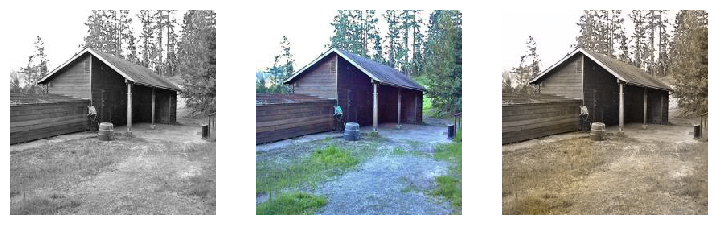

In [33]:
show_prediction(model_pre, image)

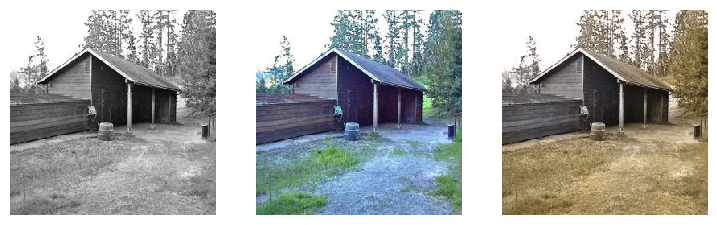

In [31]:
show_prediction(model, image)

In [34]:
model_22 = ColorizationNet().cuda()
load_model(model_pre, "models/model_0.002287.pth")

max learning rate: 0.01

In [23]:
model = ColorizationNet().cuda()
load_model(model, "models/model_0.002318.pth")

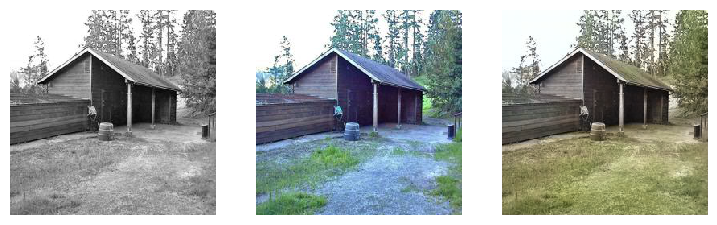

In [25]:
show_prediction(model, image)

max learning rate: 0.03

In [24]:
model = ColorizationNet().cuda()
load_model(model, "models/model_0.002401.pth")

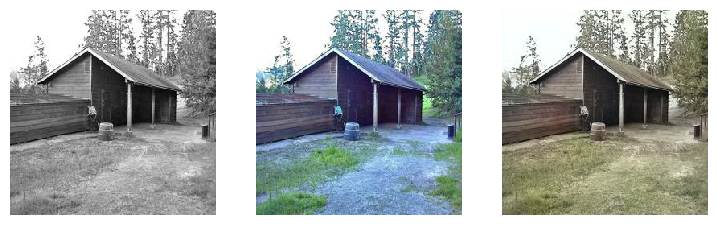

In [25]:
show_prediction(model, image)